<a href="https://colab.research.google.com/github/lhmin0614/CS492_Coursework1/blob/main/Q1_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time

drive.mount('/content/drive')
mat = loadmat('/content/drive/MyDrive/CS492_teamProject/face.mat')

X = mat['X']
y = mat['l'][0]

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def plotImages(images_arr):
    arr_len = len(images_arr)
    fig, axes = plt.subplots(arr_len//5, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(ndimage.rotate(img, -90, reshape=True))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

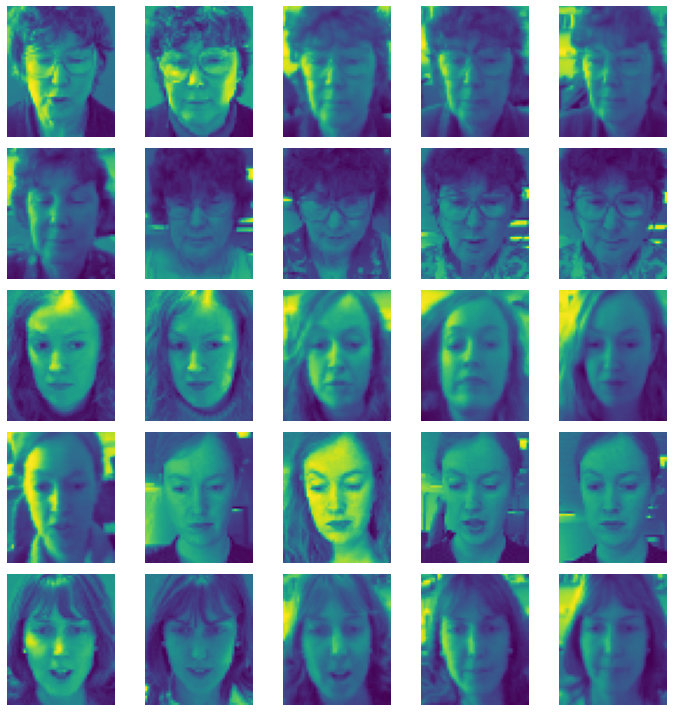

In [10]:
#visualize original images
X_visualize = [ vectors.reshape((46, 56))/255 for vectors in np.asarray(np.matrix(X).T)]
plotImages(X_visualize[:25])

In [11]:
#train/test split

train_X = [i[[True, True, True, True, False]*104] for i in X]      #split each sublist
test_X  = [i[[False, False, False, False, True]*104] for i in X]      #split each sublist
train_y = y[[True, True, True, True, False]*104]
test_y  = y[[False, False, False, False, True]*104]

print("<<Data dimension>>")
print("train_X : ", len(train_X)," * ", len(train_X[0]))
print("test_X  : ", len(test_X)," * ",  len(test_X[0]))
print("train_y : ", len(train_y))
print("test_y  : ", len(test_y))

<<Data dimension>>
train_X :  2576  *  416
test_X  :  2576  *  104
train_y :  416
test_y  :  104


<mean face>


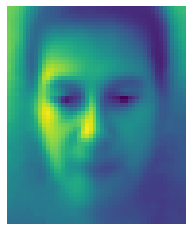

In [12]:
avg_X = [ sum(i)/len(i) for i in train_X ]   #average value of each pixel
print("<mean face>")
plt.imshow(ndimage.rotate(np.asarray(avg_X).reshape(46, 56), -90, reshape=True))
plt.axis('off')
plt.show()

sub_X = [ list(np.asarray(x) - x_bar) for x, x_bar in zip(train_X, avg_X) ]
A = np.matrix(sub_X)
S = np.dot(A, A.T)#version1
#S = np.dot(A.T, A)#version 2  :  use low-dimension S


In [13]:
start = time.time()
eigvals, eigvecs_column = np.linalg.eigh(S)  
stop = time.time()
print(f"Training time: {stop - start}s")

# we can use eigh method since AAT is symmetric matrix
# eigh method automatically sorts eigvals (ascending order)

Training time: 3.907799243927002s


In [ ]:
#version2
eigvecs_column = np.dot(A, eigvecs_column)

Text(0, 0.5, 'Real Value')

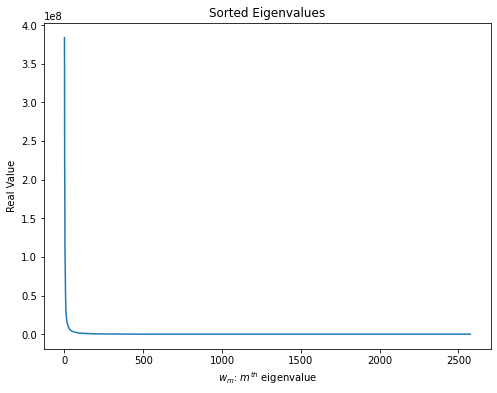

In [14]:
# Plot descending magnitude of eigenvalue agaisnt respective index of eigenvalue
# eig_pairs = [(np.abs(eigvals[i]), eigvecs_column[:,i]) for i in range(len(eigvals))]
# eig_pairs.sort(reverse=True, key=(lambda x: x[0]))
# sorted_eigvecs = [j for i, j in eig_pairs]

plt.figure(figsize=(8.0, 6.0))
plt.plot(range(len(eigvals)), eigvals[::-1])
plt.title('Sorted Eigenvalues')
plt.xlabel('$w_{m}$: $m^{th}$ eigenvalue')
plt.ylabel('Real Value')

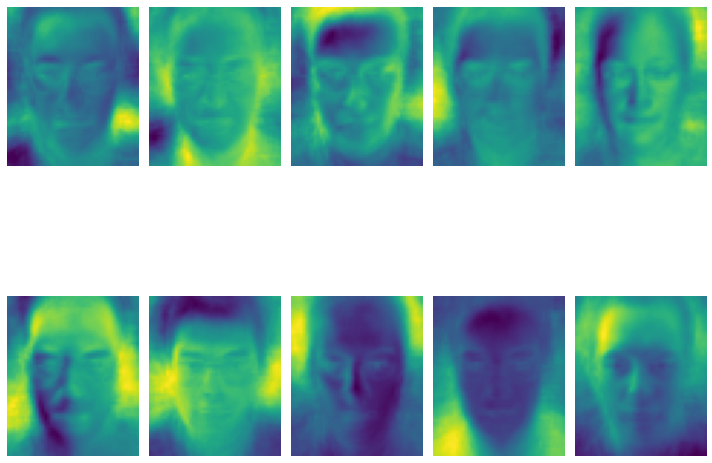

In [15]:
M=10
eigvecs = eigvecs_column.T
best_eigvals = eigvals[-M:]
best_eigvecs = eigvecs[-M:]

eigface = [np.asarray(vector).reshape((46, 56)) for vector in best_eigvecs]

plotImages(eigface[-10:])

In [16]:
W = np.dot(A.T, np.matrix(best_eigvecs).T) #weighted sum 된 vector가 row로 존재함

print(W.shape)              #416 * 50. W n을 row vector로 가진다

(416, 10)


In [17]:
def projection(X, avg_X, P) :
  A = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(X, avg_X) ])
  W = np.dot(A.T, P)
  return W

from sklearn.neighbors import KNeighborsClassifier

prj_X  = projection(train_X, avg_X, np.matrix(best_eigvecs).T)
validation_X = projection(test_X, avg_X, np.matrix(best_eigvecs).T)

print("print accuracy train / test")

for i in range(7):
  classifier = KNeighborsClassifier(n_neighbors = i*2+1)
  classifier.fit(prj_X.tolist(), train_y)

  score_train = classifier.score(prj_X.tolist(), train_y)
  score_test = classifier.score(validation_X.tolist(), test_y)

  print("k="+str(i*2+1)+" : " +str(score_train) + "/" + str(score_test))

print accuracy train / test
k=1 : 1.0/0.5384615384615384
k=3 : 0.6033653846153846/0.40384615384615385
k=5 : 0.5528846153846154/0.4519230769230769
k=7 : 0.4855769230769231/0.38461538461538464
k=9 : 0.4519230769230769/0.3942307692307692
k=11 : 0.43028846153846156/0.34615384615384615
k=13 : 0.39903846153846156/0.33653846153846156


In [18]:
#reconstruction
X_weighted_sum = np.dot(W, np.matrix(best_eigvecs))
X_weighted_sum.shape

X_reconst = [list(np.asarray(x).real + x_bar) for x, x_bar in zip(X_weighted_sum.tolist(), avg_X) ]

reconst_err = [np.linalg.norm(i-j) for i, j in zip(X_reconst, np.asarray(np.matrix(train_X).T))]
reconst_err_avg = sum(reconst_err)/len(reconst_err)
print("average reconstruct error when M : "+ str(M)+" is " + str(reconst_err_avg))

average reconstruct error when M : 10 is 1977.0488118366093


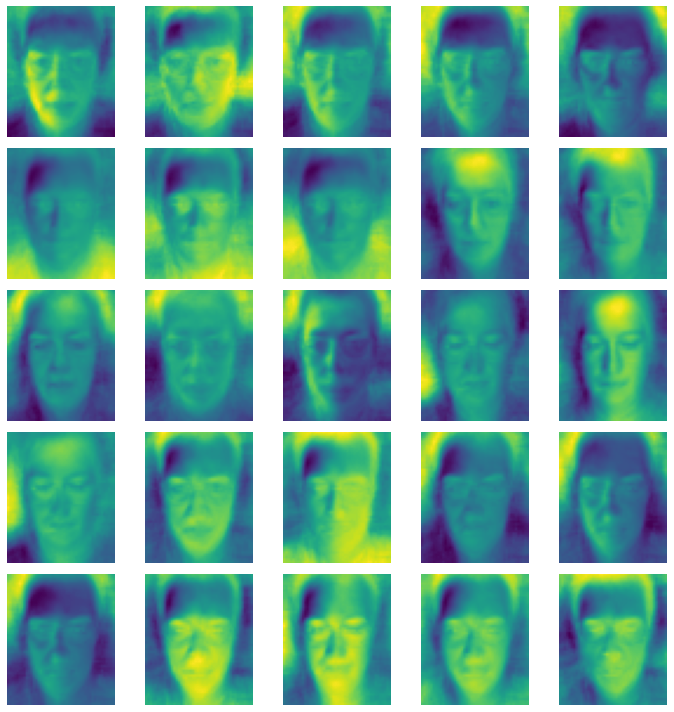

In [19]:
X_reconst_vis = [np.asarray(vector).reshape((46, 56)) for vector in X_reconst]

plotImages(X_reconst_vis[:25])